# 作业：手写数字加法机

本文件是与集智学园出品的系列课程“火炬上的深度学习”配套的作业notebook。本作业要求学员构造一个卷积神经网，输入两张手写数字图片，输出这两个数字的和。

本文件提供了一个完成做的大框架，学员需要自行修改、添加代码，从而完成任务

本文件是集智学园http://campus.swarma.org 出品的“火炬上的深度学习”第III课的配套源代码


In [2]:
# 导入所需要的包，请保证torchvision已经在你的环境中安装好
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [ ]:

# 定义需要用到的超参数
image_size = 28  #图像的总尺寸28*28
num_classes = 18  #标签的范围
batch_size = 64


# 加载MINIST数据，如果没有下载过，就会在当前路径下新建/data子目录，并把文件存放其中

train_dataset = dsets.MNIST(root='./data',  #文件存放路径
                            train=True,   #提取训练集
                            transform=transforms.ToTensor(),  #将图像转化为Tensor
                            download=True)

test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

# 由于每一个样本需要输入两个图片，因此每一个loader和sampler都有两个

sampler1 = torch.utils.data.sampler.SubsetRandomSampler(
    np.random.permutation(range(len(train_dataset))))
sampler2 = torch.utils.data.sampler.SubsetRandomSampler(
    np.random.permutation(range(len(train_dataset))))

# 训练数据的两个加载器
train_loader1 = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           sampler = sampler1
                                           )
train_loader2 = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = False,
                                           sampler = sampler2
                                           )

# 校验数据和测试数据都各自有两套
val_size = 5000
val_indices1 = range(val_size)
val_indices2 = np.random.permutation(range(val_size))
test_indices1 = range(val_size, len(test_dataset))
test_indices2 = np.random.permutation(test_indices1)
val_sampler1 = torch.utils.data.sampler.SubsetRandomSampler(val_indices1)
val_sampler2 = torch.utils.data.sampler.SubsetRandomSampler(val_indices2)

test_sampler1 = torch.utils.data.sampler.SubsetRandomSampler(test_indices1)
test_sampler2 = torch.utils.data.sampler.SubsetRandomSampler(test_indices2)

val_loader1 = torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size = batch_size,
                                        shuffle = False,
                                        sampler = val_sampler1
                                        )
val_loader2 = torch.utils.data.DataLoader(dataset = test_dataset,
                                        batch_size = batch_size,
                                        shuffle = False,
                                        sampler = val_sampler2
                                        )
test_loader1 = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False,
                                         sampler = test_sampler1
                                         )
test_loader2 = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False,
                                         sampler = test_sampler2
                                         )

<class 'torchvision.datasets.mnist.MNIST'>


# MINST Adder

为了实现加法器，需要同时处理两个手写体数字图像，并对它进行相应的图像处理
因此，网络的架构为两个卷积神经网络，串联上两个全链接层

In [107]:
depth = [4, 8]
class MINSTAdder(nn.Module):
   def __init__(self):
       super(MINSTAdder, self).__init__()
       self.linearInputSize = image_size // 4 * image_size // 4 * depth[1]
       self.net_pool = nn.MaxPool2d(2, 2)
       #处理第一个图像处理用的卷积网络部件
       self.net1_conv1 = nn.Conv2d(1, depth[0], 5, padding = 2)
       self.net1_conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2)
        
       #处理第二个图像处理用的卷积网络部件
       self.net2_conv1 = nn.Conv2d(1, depth[0], 5, padding = 2)
       self.net2_conv2 = nn.Conv2d(depth[0], depth[1], 5, padding = 2)
        
       #后面的全连阶层
       self.fc1 = nn.Linear(2 * self.linearInputSize, 1024)
       self.fc2 = nn.Linear(1024, 256)
       self.fc3 = nn.Linear(256, 1)

   def forward(self, x, y, training = True):
       #第一张图像的处理流程
       x = F.relu(self.net1_conv1(x))
       x = self.net_pool(x)
       x = F.relu(self.net1_conv2(x))
       x = self.net_pool(x)
       x = x.view(-1, image_size // 4 * image_size // 4 * depth[1])
        
       #第二张图像的处理流程
       y = F.relu(self.net2_conv1(y))
       y = self.net_pool(y)
       y = F.relu(self.net2_conv2(y))
       y = self.net_pool(y)
       y = y.view(-1, image_size // 4 * image_size // 4 * depth[1])
        
       # 将前两部处理得到的张量并列到一起，喂给两层全链接前馈网络，最后输出预测数值
       z = torch.cat((x, y), 1) # 两个行向量按行连接
       z = F.relu(self.fc1(z))
       z = F.dropout(z, training=self.training, p=0.125)
       z = F.relu(self.fc2(z))
       z = self.fc3(z)
       return z

# 计算准确度的函数（有多少数字给出了严格的正确输出结果）
def rightness(y, target):
   '''y是预测值，target真实标签值(0-18)'''
   out = torch.round(y * 18).type(torch.LongTensor)
   out = out.eq(target).sum()
   out1 = y.size()[0]
   return (out, out1) # 正确数out，样本数out1

In [ ]:
#将网络定义为一个预测器，来对加法的结果进行预测，因此用MSE平均平房误差作为我们的损失函数
net = MINSTAdder()
criterion = nn.MSELoss()

In [150]:
#开始训练循环，本部分代码需要补齐
optimizer = optim.SGD(net.parameters(), lr = 0.00001, momentum = 0.9)
num_epochs = 20
records = []

for epoch in range(num_epochs):
   losses = []
   # 一个关键技术难点是对两个数据加载器进行读取成对儿的数据。我们的办法是通过zip命令，将loader1和2并列在一起，一对一对的读取数据
   for idx, data in enumerate(zip(train_loader1, train_loader2)):
       ((x1, y1), (x2, y2)) = data
       optimizer.zero_grad()
       net.train()
       outputs = net(x1, x2)
       labels = (y1 + y2) * 1.0 / num_classes # labels的尺寸为64
       labels = labels.unsqueeze(1)
       loss = criterion(outputs, labels)
       losses.append(loss.data)

       loss.backward()
       optimizer.step()
       
       if idx % 200 == 0:
           #每间隔一定周期就打印一下训练集、校验集的准确率结果
           net.eval()
           val_losses = []
           val_rights = []
           
           for ((val_data1, val_label1), (val_data2, val_label2)) in zip(val_loader1, val_loader2):
               pred = net(val_data1, val_data2) 
               val_label = (val_label1 + val_label2) * 1.0 / num_classes
               val_label = val_label.unsqueeze(1)
               val_loss = criterion(pred, val_label)
               val_losses.append(val_loss.data)
               val_rights.append(rightness(pred, (val_label1 + val_label2).unsqueeze(1))) 
           right_ratio = sum([tup[0] for tup in val_rights]) / sum([tup[1] for tup in val_rights])
           print('第{}周期，第({}/{})个批，训练误差：{:.4f}, 校验误差：{:.4f}, 校验集准确率：{:.1f}%'.format(
               epoch, idx, len(train_loader1),
               np.mean(losses), np.mean(val_losses), right_ratio * 100))
           records.append(right_ratio)

第0周期，第(0/938)个批，训练误差：0.0021, 校验误差：0.0027, 校验集准确率：66.6%
第0周期，第(200/938)个批，训练误差：0.0019, 校验误差：0.0026, 校验集准确率：67.1%
第0周期，第(400/938)个批，训练误差：0.0019, 校验误差：0.0027, 校验集准确率：66.4%
第0周期，第(600/938)个批，训练误差：0.0019, 校验误差：0.0027, 校验集准确率：67.2%
第0周期，第(800/938)个批，训练误差：0.0019, 校验误差：0.0027, 校验集准确率：66.4%
第1周期，第(0/938)个批，训练误差：0.0018, 校验误差：0.0026, 校验集准确率：66.9%
第1周期，第(200/938)个批，训练误差：0.0019, 校验误差：0.0026, 校验集准确率：67.8%
第1周期，第(400/938)个批，训练误差：0.0019, 校验误差：0.0028, 校验集准确率：66.2%
第1周期，第(600/938)个批，训练误差：0.0019, 校验误差：0.0027, 校验集准确率：67.0%
第1周期，第(800/938)个批，训练误差：0.0019, 校验误差：0.0026, 校验集准确率：66.6%
第2周期，第(0/938)个批，训练误差：0.0010, 校验误差：0.0027, 校验集准确率：67.2%
第2周期，第(200/938)个批，训练误差：0.0019, 校验误差：0.0026, 校验集准确率：67.2%
第2周期，第(400/938)个批，训练误差：0.0019, 校验误差：0.0027, 校验集准确率：65.9%
第2周期，第(600/938)个批，训练误差：0.0019, 校验误差：0.0026, 校验集准确率：66.5%
第2周期，第(800/938)个批，训练误差：0.0019, 校验误差：0.0026, 校验集准确率：66.3%
第3周期，第(0/938)个批，训练误差：0.0031, 校验误差：0.0027, 校验集准确率：66.6%
第3周期，第(200/938)个批，训练误差：0.0020, 校验误差：0.0027, 校验集准确率：66.9%
第3周期，第(400/938)个批，训练误差：0.0019, 校验误差：0.0

训练80个epoch就基本到瓶颈了，校验集准确率最多70%，测试集准确率77%，分析应该是神经网络的结构问题，我觉得像这种设计到图片识别的问题，最好是转化为分类问题而不是回归问题。

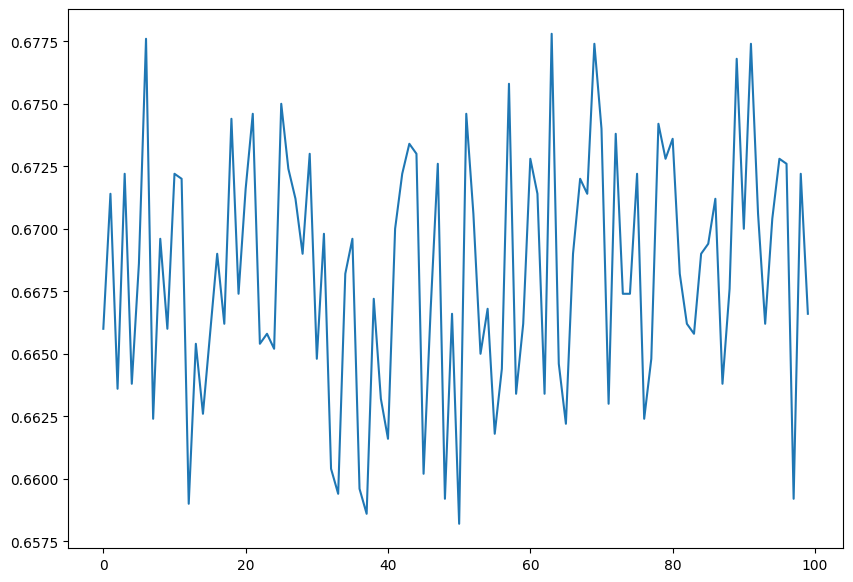

In [151]:
plt.figure(figsize = (10, 7))
plt.plot(records)

### 模型测试

In [152]:
# 在测试集上运行我们的加法机网络，并测试预测准确度

net.eval()
vals = []
for (data1, target1), (data2, target2) in zip(test_loader1, test_loader2):

    output = net(data1, data2)
    target = (target1 + target2).unsqueeze(1)
    val = rightness(output, target)
    vals.append(val)

rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0] / rights[1]
print("测试集正确率为{}".format(right_rate))


测试集正确率为0.7666000127792358


### 保存模型

In [153]:
torch.save({
    'epoch': 100,
    'model_state_dict': net.state_dict(),
}, "model_checkpoint.pth")


### 剖析神经网络

预期结果为:5，模型预测结果为：4.600924015045166


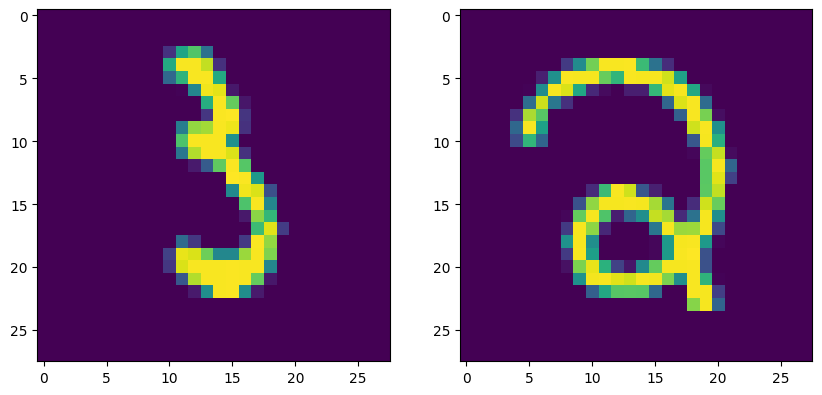

In [160]:
index1 = np.random.randint(low=0, high=10000)
index2 = np.random.randint(low=0, high=10000)
plt.figure(figsize = (10, 7))
plt.subplot(1, 2, 1)
plt.imshow(test_dataset[index1][0][0].numpy())
plt.subplot(1, 2, 2)
plt.imshow(test_dataset[index2][0][0].numpy())
input_1 = test_dataset[index1][0].unsqueeze(0)
input_2 = test_dataset[index2][0].unsqueeze(0)
label_1 = test_dataset[index1][1]
label_2 = test_dataset[index2][1]
prediction = net(input_1, input_2)
prediction = prediction.data.numpy()[0, 0]
# pred = np.round(prediction * 18)
pred = prediction * 18
print("预期结果为:{}，模型预测结果为：{}".format(label_1+label_2, pred))
